<small>
Copyright (C) 2025, École Polytechnique Fédérale de Lausanne. All Rights Reserved.
</small>

---

# Exercise 5 | Offset-free Tracking

Consider the discrete-time system

$$
\begin{aligned}
x_{k+1} &= \begin{bmatrix} 0.7115 & -0.4345 \\ 0.4345 & 0.8853 \end{bmatrix} x_k + \begin{bmatrix} 0.2173 \\ 0.0573 \end{bmatrix} u_k \\
y_k &= \begin{bmatrix} 0 & 1 \end{bmatrix} x_k + d
\end{aligned}
$$

where $d$ is an unknown constant disturbance and $x_0$ is unknown. 

The goal of this exercise is to design a controller able to track a constant output reference while fulfilling input constraints

$$
-3 \leq u_k \leq 3
$$


In [1]:
import numpy as np

A = np.array([[0.7115, -0.4345], [0.4345, 0.8853]])
B = np.array([[0.2173], [0.0573]])
C = np.array([[0, 1]])

u_max = 3.
u_min = -3.

# Dimensions
nx = B.shape[0]  # num. states
nu = B.shape[1]  # num. inputs
ny = C.shape[0]  # num. outputs
nd = 1           # num. disturbance



### Problem 1 | Observer Design

Since state and disturbances are unknown at time zero, we need to design an observer to estimate them. We call $\hat{x}$ and $\hat{d}$ the estimate of $x$ and $d$, respectively. Design an observer for the given system, and test it for the condition 
$x_0 = \begin{bmatrix} 1 & 2 \end{bmatrix}^T$, $\hat{x} = \begin{bmatrix} 3 & 0 \end{bmatrix}^T$, $\hat{d} = 0$, $d = 0.2$ with input $u = 0$.

<!-- $$x_0 = \begin{bmatrix} 1 & 2 \end{bmatrix}^\top, \hat{x} = \begin{bmatrix} 3 & 0 \end{bmatrix}^\top, \hat{d} = 0, d = 0.2, u = 0.$$ -->

**Hints:**

- You can use CVXPY to implement the MPC controller (recall exercise 4).
- To estimate the disturbance you will have to augment the state as seen in class.
- Note the eigenvalues of $(A + LC)$ are the same as those of $(A^\top + C^\top L^\top)$.
- Pole placement can be computed with the python function [`scipy.signal.place_poles`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.place_poles.html). Read the documentation for its usage.



In [2]:
d = 0.2

# x^+ = A x + B u + Bd d
# d^+ = d
# y   = C x + Cd d 
Bd = np.array([[0], [0]])
Cd = np.array([[1]])

# A_hat = [A  Bd;  0  I]
A_hat = np.vstack((
    np.hstack((A, Bd)),
    np.hstack((np.zeros((ny, nx)), np.eye(ny)))
))

# B_hat = [B; 0]
B_hat = np.vstack((B, np.zeros((nd, nu))))

# C_hat = [C  Cd]
C_hat = np.hstack((C, np.ones((ny,nd))))

poles = np.array([0.5, 0.6, 0.7])
from scipy.signal import place_poles
res = place_poles(A_hat.T, C_hat.T, poles)
L = -res.gain_matrix.T



# Test with given initial condition
num_steps = 50
x_hat_traj = np.ndarray((num_steps+1, nx))  # estimated state trajectory
d_hat_traj = np.ndarray((num_steps+1, nd))  # estimated disturbance trajectory
x_traj = np.ndarray((num_steps+1, nx))      # true state trajectory
u_traj = np.zeros((num_steps, nu))          # input trajectory

x_hat_traj[0] = np.array([3, 0])
d_hat_traj[0] = np.array([0])
x_traj[0] = np.array([1, 2])

# Simulation
for k in range(num_steps):
	# True system
	x_traj[k+1] = A @ x_traj[k]
	

	# Estimation	
	yk = C @ x_traj[k] + Cd @ np.array(d).reshape((-1,))
	tmp = A_hat @ np.concatenate((x_hat_traj[k], d_hat_traj[k])) + L @ (C @ x_hat_traj[k] + Cd @ d_hat_traj[k] - yk)
	x_hat_traj[k+1] = tmp[:nx]
	d_hat_traj[k+1] = tmp[nx:]



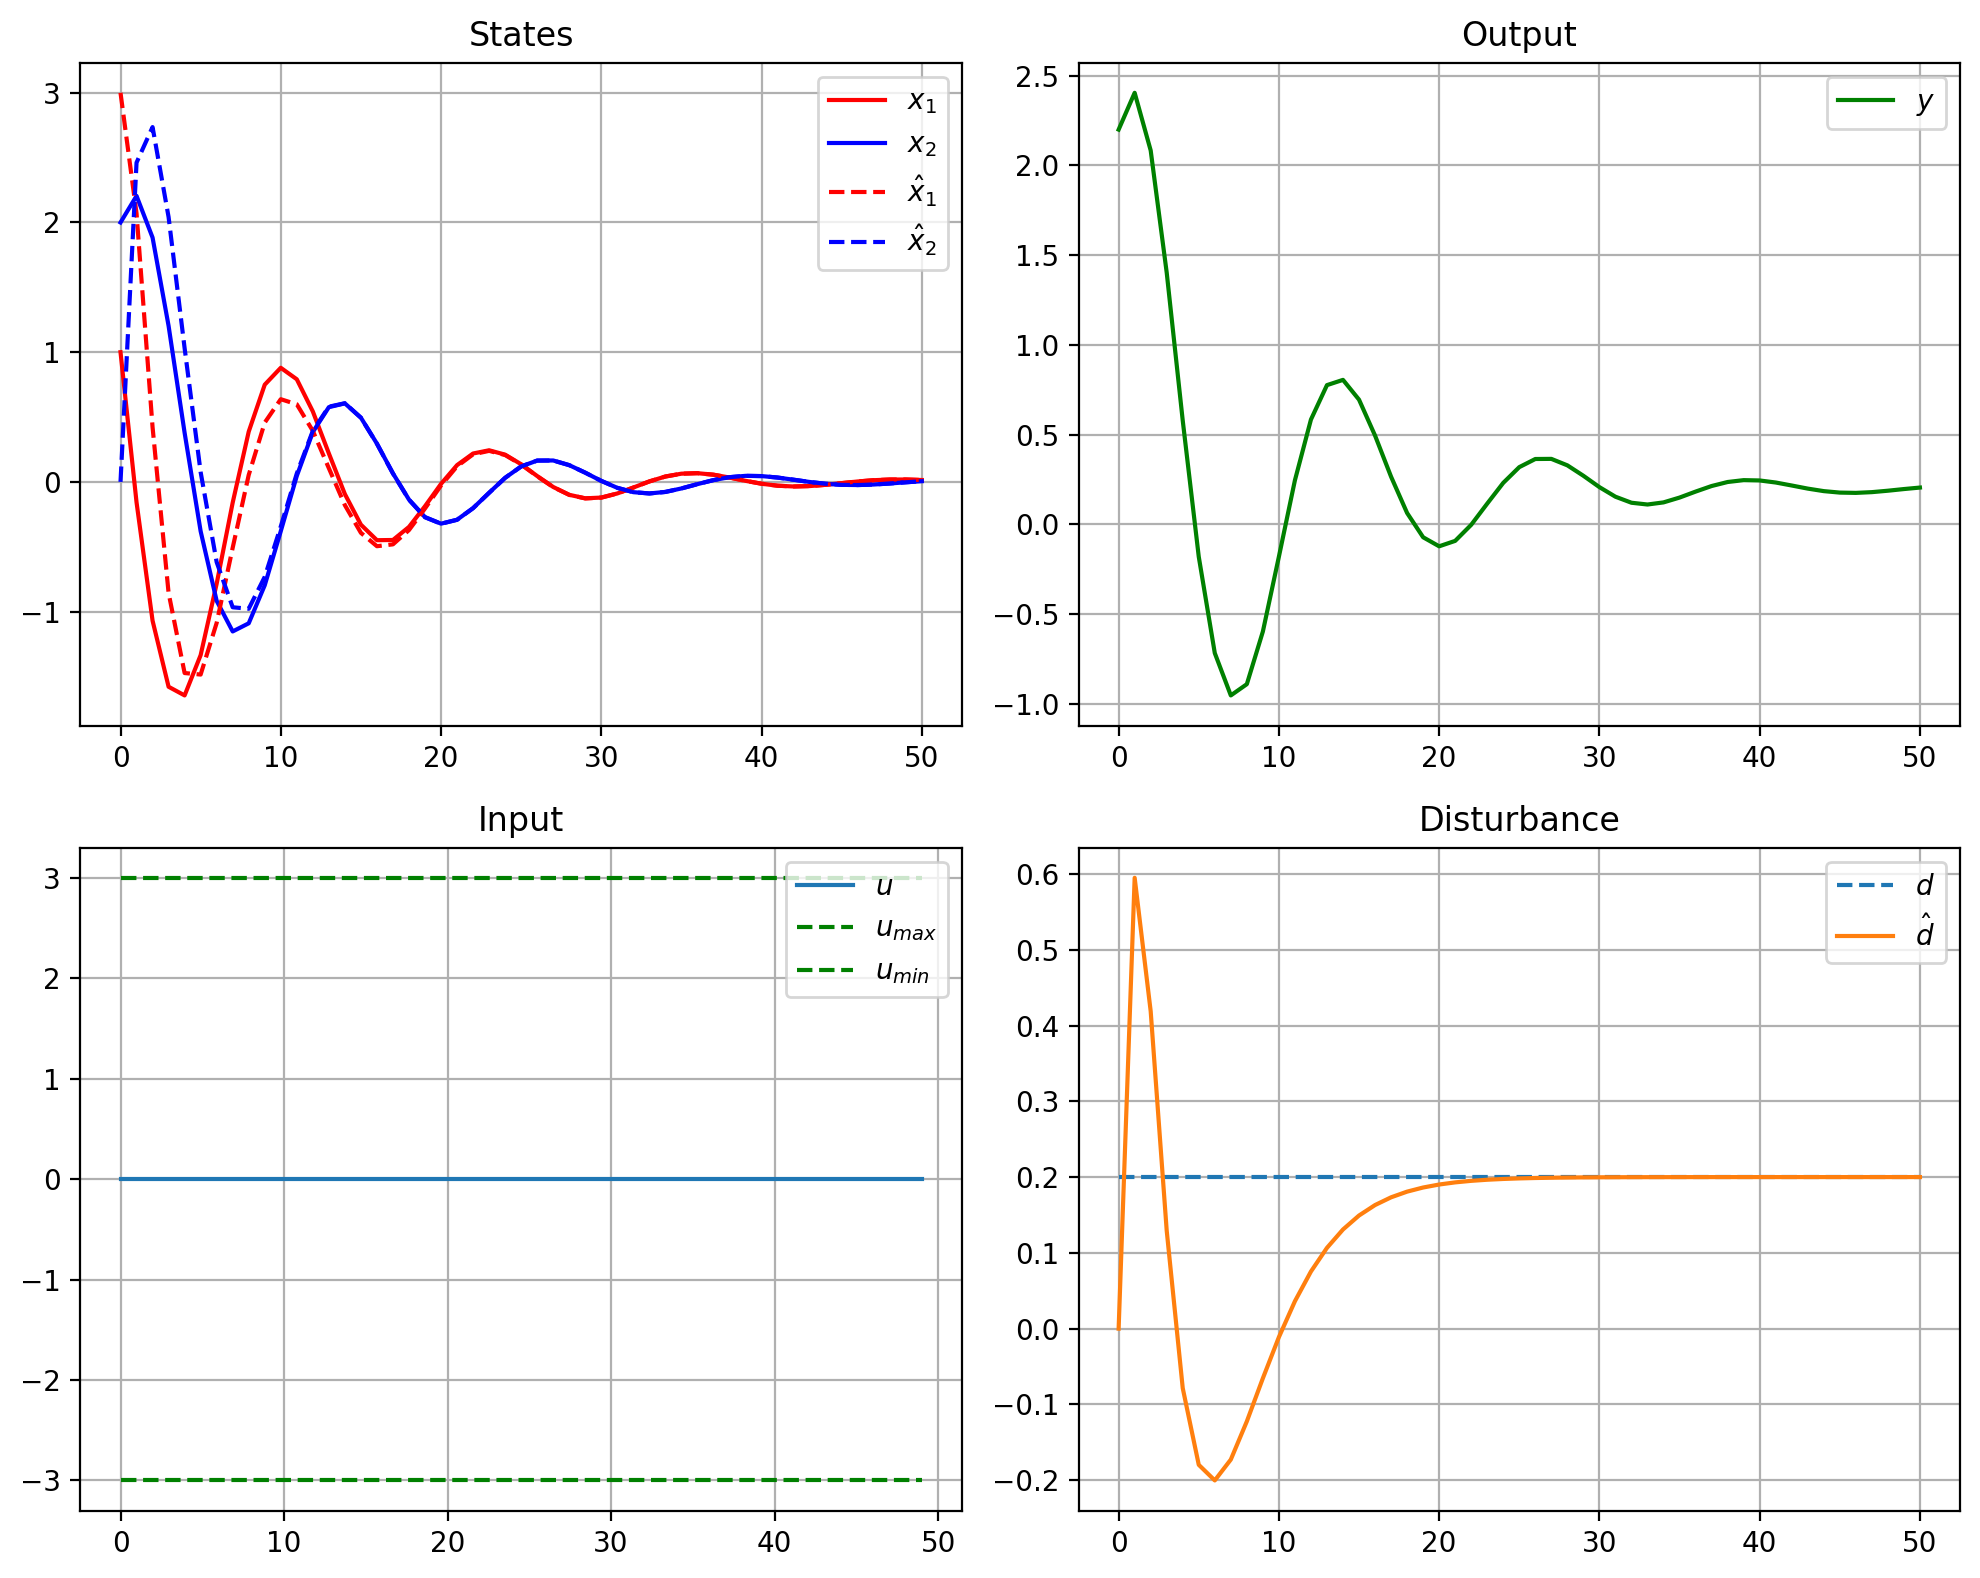

In [3]:
## Visualization

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from typing import Optional
def plot_trajs(
		x_hat_traj: np.ndarray,    # estimated states trajectory
		d_hat_traj: np.ndarray,    # estimated disturbance trajectory
		x_traj: np.ndarray,        # true states trajectory
		u_traj: np.ndarray,        # input trajectory
		d: float,                  # true disturbance
		r: Optional[float] = None  # reference
		):

	fig, axs = plt.subplots(2, 2, figsize=(10, 8))

	# --- (1,1) x and x_hat ---
	axs[0, 0].plot(x_traj[:, 0], 'r', label=r'$x_1$')
	axs[0, 0].plot(x_traj[:, 1], 'b', label=r'$x_2$')
	axs[0, 0].plot(x_hat_traj[:, 0], 'r--', label=r'$\hat{x}_1$')
	axs[0, 0].plot(x_hat_traj[:, 1], 'b--', label=r'$\hat{x}_2$')
	axs[0, 0].set_title("States")
	axs[0, 0].legend()
	axs[0, 0].grid()

	# --- (1,2) y and r ---
	y_traj = x_traj @ C.T + d * np.ones_like(x_traj @ C.T)
	axs[0, 1].plot(y_traj, 'g', label=r'$y$')
	if r is not None:
		axs[0, 1].plot(r * np.ones_like(y_traj), 'k--', label=r'$r$')
	axs[0, 1].set_title("Output")
	axs[0, 1].legend()
	axs[0, 1].grid()

	# --- (2,1) u ---
	axs[1, 0].plot(u_traj, label=r'$u$')
	axs[1, 0].plot(u_max * np.ones_like(u_traj), 'g--', label=r'$u_{max}$')
	axs[1, 0].plot(u_min * np.ones_like(u_traj), 'g--', label=r'$u_{min}$')
	axs[1, 0].set_title("Input")
	axs[1, 0].legend()
	axs[1, 0].grid()

	# --- (2,2) d and d_hat ---
	axs[1, 1].plot(d * np.ones_like(d_hat_traj), '--', label=r'$d$')
	axs[1, 1].plot(d_hat_traj, label=r'$\hat{d}$')
	axs[1, 1].set_title("Disturbance")
	axs[1, 1].legend()
	axs[1, 1].grid()

	plt.tight_layout()
	plt.show()


plot_trajs(x_hat_traj, d_hat_traj, x_traj, u_traj, d)

### Problem 2 | Steady-state target computation

Given the system above, and a reference $r$, use CVXPY to compute a steady state for the system that minimizes $u^2$.

In [4]:
import cvxpy as cp
from typing import Tuple

def compute_steady_state(d_hat: np.ndarray, r: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
	"""
	Compute the steady-state state xs and input us that minimize us^2,
	subject to the system steady-state equations and input constraints.
	"""
	d_hat = np.array(d_hat).reshape((-1,))
	r = np.array(r).reshape((-1,))

	xs_var = cp.Variable(nx, name='xs')
	us_var = cp.Variable(nu, name='us')

	# Objective: minimize input squared
	ss_obj = cp.quad_form(us_var, np.eye(nu))
	
	# Constraints: steady-state and input bounds
	ss_cons = [
		us_var >= u_min,
		us_var <= u_max,
		xs_var == A @ xs_var + B @ us_var + Bd @ d_hat,
		r == C @ xs_var + Cd @ d_hat
	]

	prob = cp.Problem(cp.Minimize(ss_obj), ss_cons)
	prob.solve()
	assert prob.status == cp.OPTIMAL

	return xs_var.value, us_var.value
    
xs, us = compute_steady_state(0, 1)
print(f"The steady-state target are:\nxs = {xs}\nus = {us}")

The steady-state target are:
xs = [2.47503558e-04 1.00000000e+00]
us = [1.99986841]


## Problem 3 | MPC tracking
Implement an MPC controller to track an output reference signal $r$.

Confirm that the estimates converge to the true values, the output converges to the reference
and that the input does not violate the constraints by plotting the result for references $r = 1$
and $r = 0.5$. Use the same initial conditions as in problem 1.

**Hints:**

- Use a terminal set of $\mathcal{X}_f = \mathbb{R}^n$ and a terminal cost of $V_f (x_N) = \Delta x_N^\top P \Delta x_N$ where $P$ is the solution of $P−A^\top PA=Q$. 

- These correspond to a terminal controller $\pi_f(\cdot) = 0$. Note that this is a valid terminal controller
because the system is stable.

- You can use the function [`scipy.linalg.solve_discrete_lyapunov`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_discrete_lyapunov.html) to compute $P$.

- Good values for the horizon and stage costs are: $N = 5, Q= I, R = I$.

- In the previous exercise you designed an observer specifying the eigenvalues of the estimation
error state-update matrix. Eigenvalues with a small norm will speed up the estimation process,
but may increase the initial overshoot of the estimate $d$. A large $d$ can cause the problem of
computing the set-point to be infeasible. Use moderate eigenvalues (e.g. $[0.5, 0.6, 0.7]$).

In [5]:
## MPC settings
N = 5           # horizon length
num_steps = 50  # number of steps of closed-loop simulation
Q = np.eye(2)
R = np.eye(1)


## Compute the P in terminal cost: x'Px/2
from scipy.linalg import solve_discrete_lyapunov
P = solve_discrete_lyapunov(A, Q)


## Formulate MPC problem (_var stands for variables, _par stands for parameters)

x_var = cp.Variable((N+1, nx), name='x')
u_var = cp.Variable((N, nu), name='u')
xs_par = cp.Parameter((nx,), name='xs')          # steady-state xs
us_par = cp.Parameter((nu,), name='us')          # steady-state us
x0_hat_par = cp.Parameter(nx, name='x0_hat')     # (estimated) initial state x0
d_hat_par = cp.Parameter(nd, 'd_hat')            # (estimated) disturbance
ref_par = cp.Parameter(ny, 'ref')                # reference


# Cost function
mpc_obj  = 0
for i in range(N):
	mpc_obj += 0.5 * cp.quad_form(x_var[i] - xs_par, Q)
	mpc_obj += 0.5 * cp.quad_form(u_var[i] - us_par, R)
mpc_obj += 0.5 * cp.quad_form(x_var[-1] - xs_par, P)

# Constraints
mpc_cons = []
mpc_cons.append(u_var <= u_max)
mpc_cons.append(u_var >= u_min)
mpc_cons += [x_var[0] == x0_hat_par]

mpc_cons += [x_var[1:] == x_var[:-1] @ A.T + u_var @ B.T + d_hat_par @ Bd.T]  # dynamics (vectorized)
# Optionally: the dynamics constraints can be written with a loop
# for i in range(N):
# 	mpc_cons.append(x_var[i+1] == A @ x_var[i] + B @ u_var[i] + Bd @ d_hat_par)


mpc_prob = cp.Problem(cp.Minimize(mpc_obj), mpc_cons)

d = np.array([0.2]) # disturbance
r = np.array([1])   # reference  # Can change it to 0.5

x_traj = np.zeros((num_steps+1, nx))
u_traj = np.zeros((num_steps, nu))
x_hat_traj = np.zeros((num_steps+1, nx))
d_hat_traj = np.zeros((num_steps+1, nd))


c:\Users\killi\Desktop\MPC-Course-EPFL\.env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


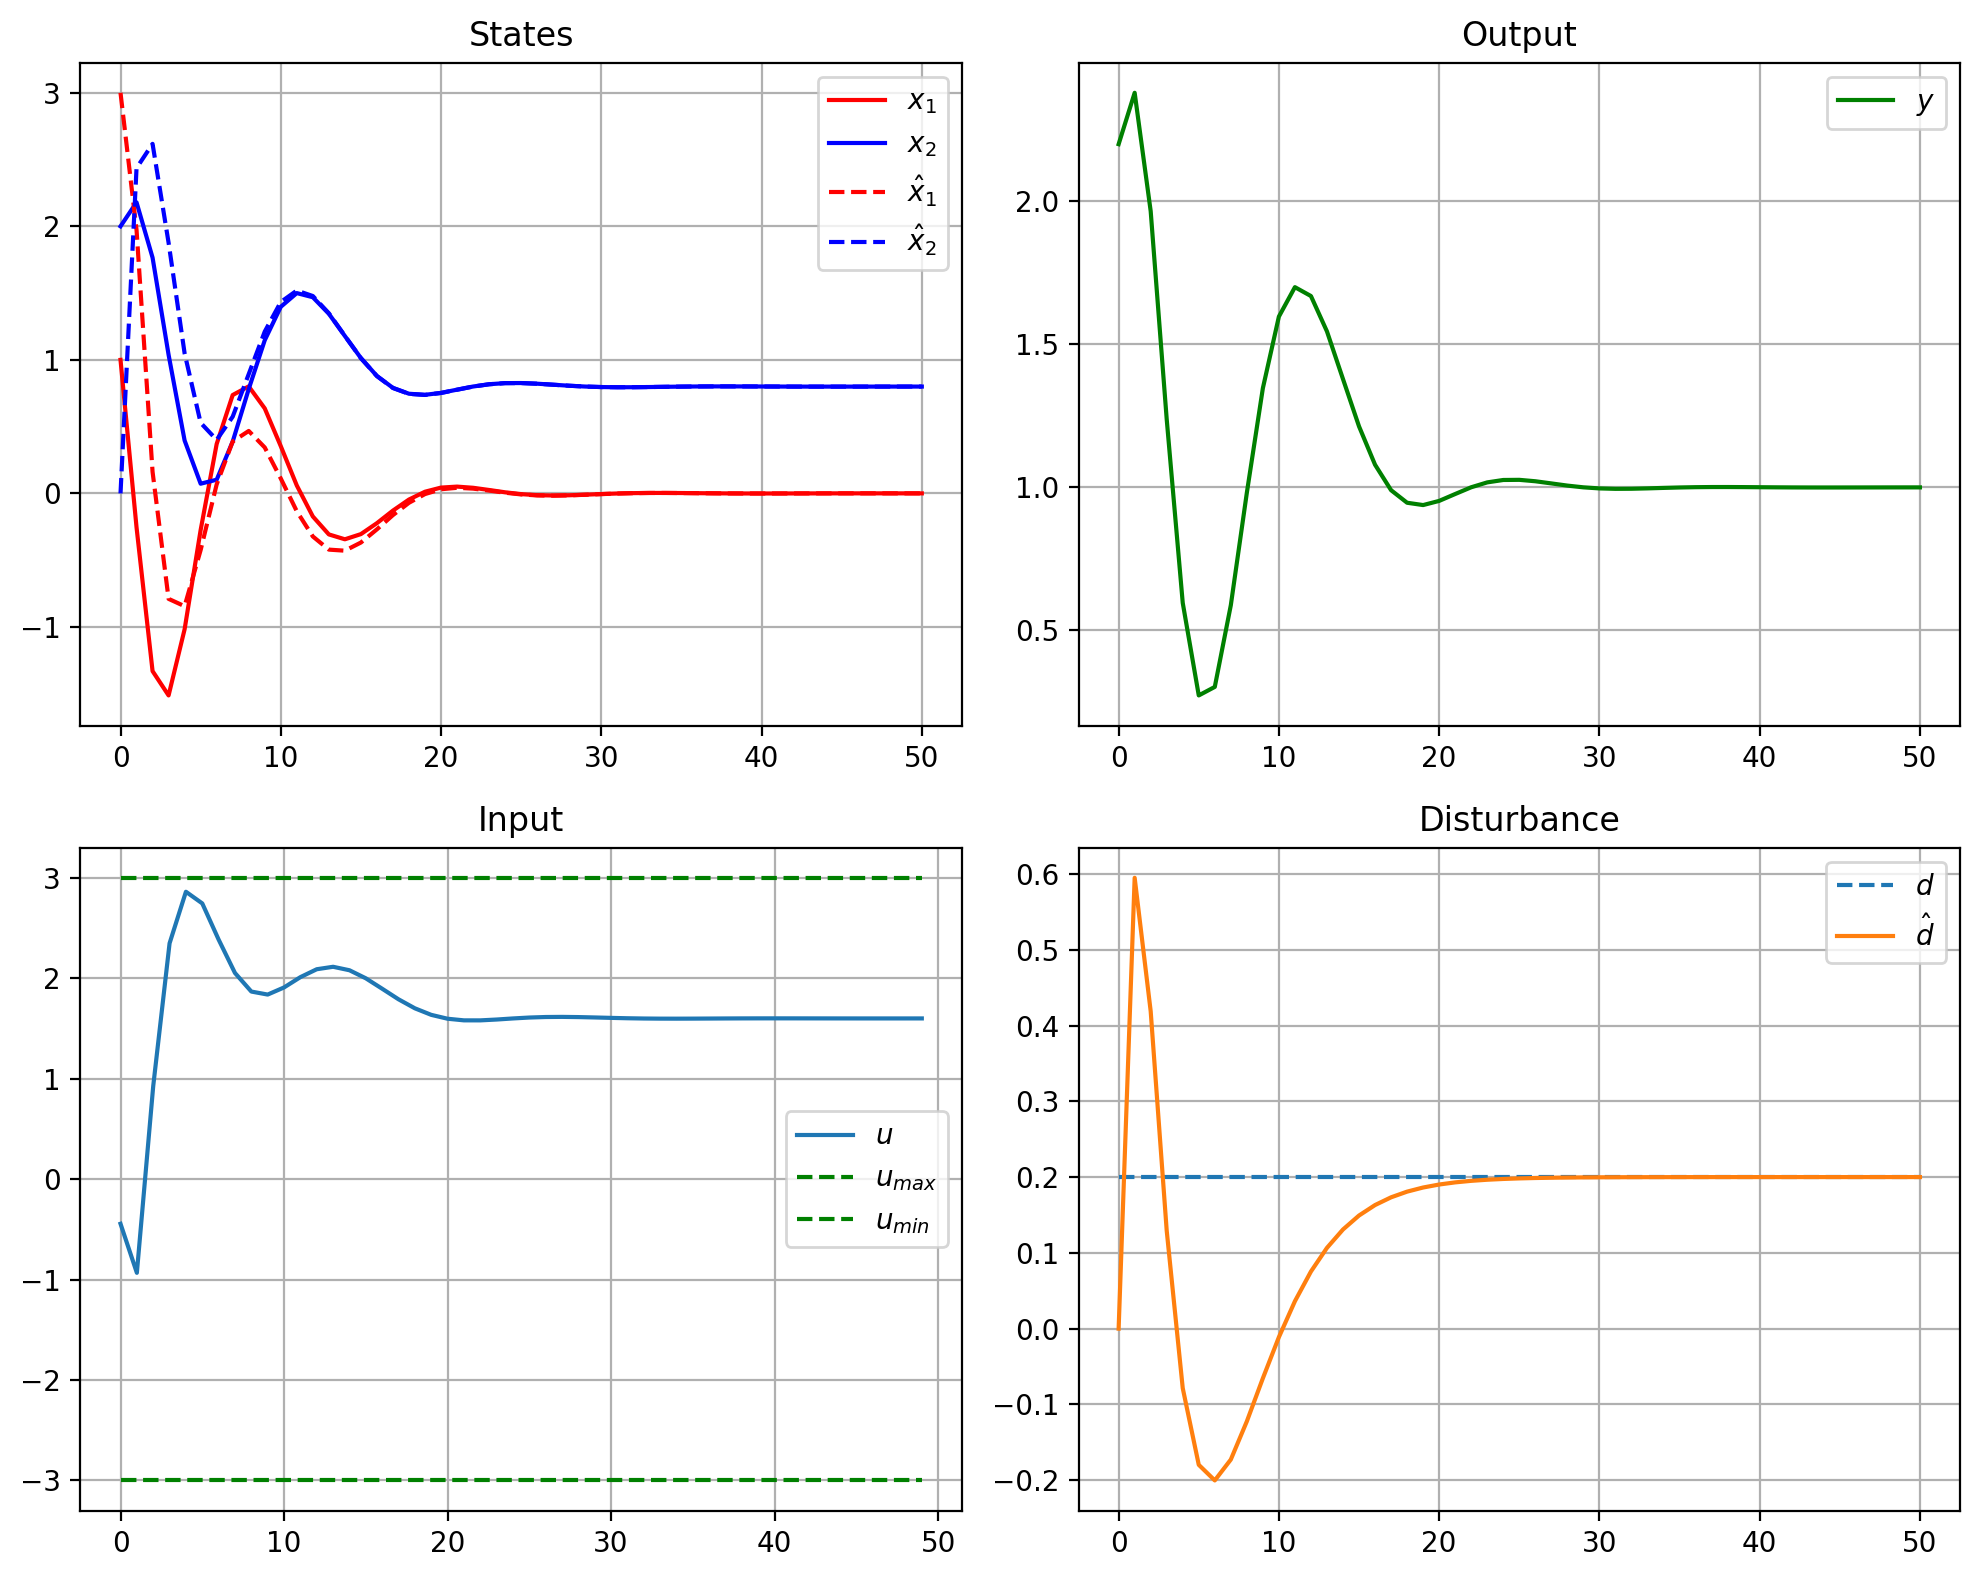

In [6]:

# Initial conditions
x0 = np.array([1, 2])
x0_hat = np.array([3, 0])
d0_hat = np.array([0])

x_traj[0] = x0
x_hat_traj[0] = x0_hat
d_hat_traj[0] = d0_hat



## Closed loop simulation
for k in range(num_steps):
	xs, us = compute_steady_state(d_hat_traj[k], r)

	# update parameter for MPC problem
	xs_par.value = xs
	us_par.value = us
	x0_hat_par.value = x_hat_traj[k]
	d_hat_par.value = d_hat_traj[k]
	mpc_prob.solve()
	assert mpc_prob.status == cp.OPTIMAL

	u_traj[k] = u_var[0].value


	# Apply to the plant, simulate the system evolvement
	x_traj[k+1] = A @ x_traj[k] + B @ u_traj[k] + Bd @ d
	yk = C @ x_traj[k] + Cd @ d
    
    
    # Observer
	x_hat = np.concatenate((x_hat_traj[k], d_hat_traj[k]))
	x_hat_next = A_hat @ x_hat + B_hat @ u_traj[k] + L @ (C_hat @ x_hat - yk)
	
	x_hat_traj[k+1] = x_hat_next[:nx]
	d_hat_traj[k+1] = x_hat_next[nx:]


## Visualization
plot_trajs(x_hat_traj, d_hat_traj, x_traj, u_traj, d)